In [8]:
import tensorflow as tf
print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [9]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/KnightChaser/ML-challenge/main/EX_challenging_problems/03_power_consumption_prediction/TetuanCityPowerConsumption.csv")             # UPLOADED
print(df)

       Temperature  Humidity  Wind Speed  general diffuse flows  \
0            6.559      73.8       0.083                  0.051   
1            6.414      74.5       0.083                  0.070   
2            6.313      74.5       0.080                  0.062   
3            6.121      75.0       0.083                  0.091   
4            5.921      75.7       0.081                  0.048   
...            ...       ...         ...                    ...   
52411        7.010      72.4       0.080                  0.040   
52412        6.947      72.6       0.082                  0.051   
52413        6.900      72.8       0.086                  0.084   
52414        6.758      73.0       0.080                  0.066   
52415        6.580      74.1       0.081                  0.062   

       diffuse flows  Zone 1 Power Consumption  
0              0.119               34055.69620  
1              0.085               29814.68354  
2              0.100               29128.10127  

In [10]:
df.tail()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption
52411,7.010,72.4,0.080,0.040,0.096,31160.45627
52412,6.947,72.6,0.082,0.051,0.093,30430.41825
52413,6.900,72.8,0.086,0.084,0.074,29590.87452
52414,6.758,73.0,0.080,0.066,0.089,28958.17490
52415,6.580,74.1,0.081,0.062,0.111,28349.80989


In [11]:
df.isna().sum()

Temperature                 0
Humidity                    0
Wind Speed                  0
general diffuse flows       0
diffuse flows               0
Zone 1 Power Consumption    0
dtype: int64

In [12]:
train_dataset = df.sample(frac = 0.8, random_state = 0xCAFE)
test_dataset  = df.drop(train_dataset.index)

In [13]:
sns.pairplot(train_dataset[["Zone 1 Power Consumption", "Temperature", "Humidity", "Wind Speed", "general diffuse flows", "diffuse flows"]], diag_kind="kde")

NameError: name 'sns' is not defined

In [14]:
train_dataset.describe()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption
count,41933.000000,41933.000000,41933.000000,41933.000000,41933.000000,41933.000000
mean,18.787461,68.313306,1.961706,182.970287,74.823584,32305.005655
std,5.820681,15.555452,2.349552,264.677198,123.909821,7124.708402
min,3.247000,11.340000,0.050000,0.004000,0.011000,13895.696200
25%,14.390000,58.340000,0.078000,0.062000,0.122000,26251.711520
50%,18.740000,69.890000,0.086000,4.832000,4.324000,32247.457630
75%,22.860000,81.500000,4.915000,320.800000,100.900000,37266.885250
max,40.010000,94.800000,6.483000,1163.000000,936.000000,52204.395120


In [15]:
print(train_dataset.shape)
print(test_dataset.shape)

(41933, 6)
(10483, 6)


In [16]:
# The prdiction objective of the current model
train_target = train_dataset.pop("Zone 1 Power Consumption")
test_target  = test_dataset.pop("Zone 1 Power Consumption")

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

ss = StandardScaler()

ss.fit(train_dataset)
train_scaled = ss.transform(train_dataset)
test_scaled  = ss.transform(test_dataset)

In [18]:
print(train_scaled.shape)
print(train_target.shape)

(41933, 5)
(41933,)


In [19]:
from tensorflow import keras

def create_DNN_model(additional_layers = None):

    model = keras.Sequential()

    if additional_layers:
        for more_layer in additional_layers:
            model.add(more_layer)

    model.add(keras.layers.Dense(units = 1))

    return model

In [20]:
model = create_DNN_model([keras.layers.Dense(units = 1024, activation = "relu", input_shape = (5, )),
                          keras.layers.Dense(units = 512, activation = "relu"),
                          keras.layers.Dropout(0.3),
                          keras.layers.Dense(units = 128, activation = "relu"),
                          keras.layers.Dense(units = 64, activation = "relu"),
                          keras.layers.Dense(units = 32, activation = "relu"),
                          keras.layers.Dense(units = 16, activation = "relu"),
                         ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              6144      
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 16)                5

In [21]:
from tensorflow._api.v2.config import optimizer
model.compile(loss = "mse",                         # <-- REGRESSION
              metrics = "mae",
              optimizer = "adam")

In [22]:
from sklearn.utils import validation

early_stopping_checkpoint = keras.callbacks.EarlyStopping(patience = 20, restore_best_weights = True, mode = "auto")

history = model.fit(train_scaled, train_target,
                    epochs = 1000,
                    steps_per_epoch = 200,
                    validation_data = (test_scaled, test_target),
                    callbacks = [early_stopping_checkpoint])

Epoch 1/1000
200/200 [==============================] - 2s 8ms/step - loss: 297104480.0000 - mae: 12797.3662 - val_loss: 44151800.0000 - val_mae: 5561.5825
Epoch 2/1000
200/200 [==============================] - 1s 6ms/step - loss: 42539184.0000 - mae: 5356.9409 - val_loss: 39743068.0000 - val_mae: 5153.4033
Epoch 3/1000
200/200 [==============================] - 1s 6ms/step - loss: 40863608.0000 - mae: 5196.9775 - val_loss: 39041168.0000 - val_mae: 5086.4907
Epoch 4/1000
200/200 [==============================] - 1s 7ms/step - loss: 40602780.0000 - mae: 5162.3257 - val_loss: 39089084.0000 - val_mae: 5085.3672
Epoch 5/1000
200/200 [==============================] - 1s 6ms/step - loss: 40332644.0000 - mae: 5142.9702 - val_loss: 38687180.0000 - val_mae: 5059.8857
Epoch 6/1000
200/200 [==============================] - 1s 6ms/step - loss: 40236380.0000 - mae: 5124.4248 - val_loss: 38646904.0000 - val_mae: 5028.9351
Epoch 7/1000
200/200 [==============================] - 1s 7ms/step - loss

Epoch 54/1000
200/200 [==============================] - 2s 8ms/step - loss: 38030036.0000 - mae: 4880.8667 - val_loss: 36335092.0000 - val_mae: 4800.0928
Epoch 55/1000
200/200 [==============================] - 2s 8ms/step - loss: 37732692.0000 - mae: 4858.2930 - val_loss: 36034480.0000 - val_mae: 4786.0200
Epoch 56/1000
200/200 [==============================] - 1s 7ms/step - loss: 37690764.0000 - mae: 4857.5273 - val_loss: 36198864.0000 - val_mae: 4810.9849
Epoch 57/1000
200/200 [==============================] - 2s 8ms/step - loss: 37776480.0000 - mae: 4858.1069 - val_loss: 36293684.0000 - val_mae: 4823.5396
Epoch 58/1000
200/200 [==============================] - 2s 9ms/step - loss: 37619416.0000 - mae: 4845.5024 - val_loss: 36064220.0000 - val_mae: 4749.2520
Epoch 59/1000
200/200 [==============================] - 2s 9ms/step - loss: 37548124.0000 - mae: 4843.1484 - val_loss: 35741644.0000 - val_mae: 4722.0283
Epoch 60/1000
200/200 [==============================] - 2s 9ms/step -

Epoch 107/1000
200/200 [==============================] - 1s 7ms/step - loss: 36038564.0000 - mae: 4706.5830 - val_loss: 34287172.0000 - val_mae: 4599.2168
Epoch 108/1000
200/200 [==============================] - 1s 7ms/step - loss: 35990696.0000 - mae: 4697.5981 - val_loss: 34513972.0000 - val_mae: 4606.0264
Epoch 109/1000
200/200 [==============================] - 1s 7ms/step - loss: 35923804.0000 - mae: 4693.2183 - val_loss: 34406356.0000 - val_mae: 4646.0117
Epoch 110/1000
200/200 [==============================] - 1s 7ms/step - loss: 35902688.0000 - mae: 4690.5864 - val_loss: 34264588.0000 - val_mae: 4572.9961
Epoch 111/1000
200/200 [==============================] - 1s 7ms/step - loss: 35810392.0000 - mae: 4681.5381 - val_loss: 34610828.0000 - val_mae: 4622.2920
Epoch 112/1000
200/200 [==============================] - 2s 8ms/step - loss: 36084836.0000 - mae: 4706.5342 - val_loss: 34295344.0000 - val_mae: 4598.1372
Epoch 113/1000
200/200 [==============================] - 2s 8ms

200/200 [==============================] - 1s 7ms/step - loss: 35367364.0000 - mae: 4642.4580 - val_loss: 34638000.0000 - val_mae: 4642.9546
Epoch 160/1000
200/200 [==============================] - 1s 7ms/step - loss: 35350992.0000 - mae: 4633.6050 - val_loss: 33666264.0000 - val_mae: 4522.9883
Epoch 161/1000
200/200 [==============================] - 1s 7ms/step - loss: 35157680.0000 - mae: 4615.1191 - val_loss: 33918156.0000 - val_mae: 4568.7544
Epoch 162/1000
200/200 [==============================] - 1s 7ms/step - loss: 35085344.0000 - mae: 4619.7568 - val_loss: 33931296.0000 - val_mae: 4561.5088
Epoch 163/1000
200/200 [==============================] - 1s 7ms/step - loss: 35318856.0000 - mae: 4627.3931 - val_loss: 34597548.0000 - val_mae: 4621.9004
Epoch 164/1000
200/200 [==============================] - 1s 7ms/step - loss: 35295380.0000 - mae: 4621.3247 - val_loss: 33902636.0000 - val_mae: 4524.7866
Epoch 165/1000
200/200 [==============================] - 1s 7ms/step - loss: 3

200/200 [==============================] - 2s 8ms/step - loss: 34737632.0000 - mae: 4575.7661 - val_loss: 33973396.0000 - val_mae: 4496.9004
Epoch 212/1000
200/200 [==============================] - 2s 8ms/step - loss: 34709516.0000 - mae: 4579.0312 - val_loss: 33271382.0000 - val_mae: 4489.2227
Epoch 213/1000
200/200 [==============================] - 2s 10ms/step - loss: 34682916.0000 - mae: 4567.9033 - val_loss: 33140210.0000 - val_mae: 4444.0688
Epoch 214/1000
200/200 [==============================] - 2s 9ms/step - loss: 34768448.0000 - mae: 4579.1187 - val_loss: 33506364.0000 - val_mae: 4504.8931
Epoch 215/1000
200/200 [==============================] - 2s 9ms/step - loss: 34499488.0000 - mae: 4565.9780 - val_loss: 33208766.0000 - val_mae: 4463.4468
Epoch 216/1000
200/200 [==============================] - 2s 8ms/step - loss: 34654964.0000 - mae: 4568.8716 - val_loss: 33161038.0000 - val_mae: 4480.7168
Epoch 217/1000
200/200 [==============================] - 2s 10ms/step - loss:

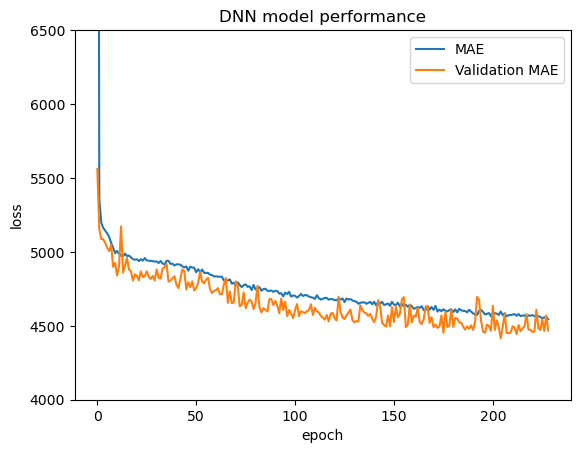

In [23]:
import matplotlib.pyplot as plt

plt.title("DNN model performance")

plt.plot(history.history["mae"], label = "MAE")
plt.plot(history.history["val_mae"], label = "Validation MAE")

# plt.ylim([min(min(history.history["mae"]), min(history.history["val_mae"])) - 1000, max(max(history.history["mae"]), max(history.history["val_mae"])) + 1000])
plt.ylim([4000, 6500])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

plt.show()

In [24]:
model.evaluate(test_scaled, test_target)

328/328 [==============================] - 0s 793us/step - loss: 33012412.0000 - mae: 4450.2090


[33012412.0, 4450.208984375]

328/328 [==============================] - 0s 628us/step


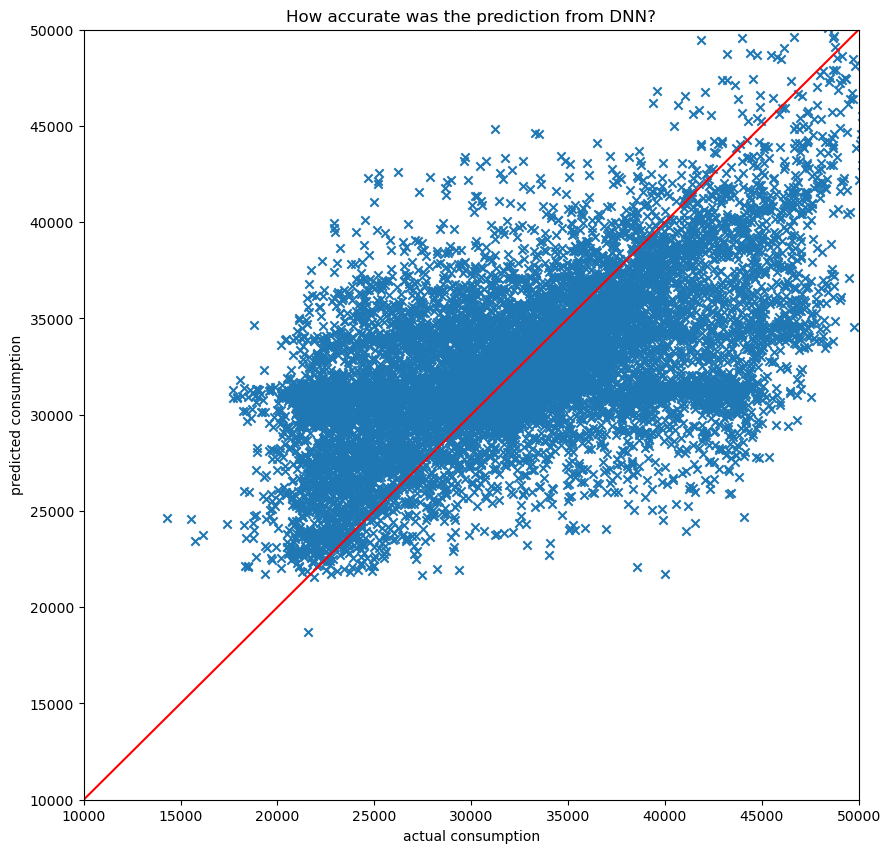

In [25]:
# Prediction Visualization
prediction = model.predict(test_scaled)

plt.figure(figsize = (10, 10))


plt.scatter(test_target, prediction, marker = "x")

plt.title("How accurate was the prediction from DNN?")
plt.xlabel("actual consumption")
plt.ylabel("predicted consumption")

axis_range = [10000, 50000]
plt.plot(axis_range, axis_range, linestyle = "solid", color = "red")
plt.xlim(axis_range)
plt.ylim(axis_range)

plt.show()

# If the scattered plots more nearly approximates to the red diagonal line which represents the exact
# ratio of 1:1 for prediction:real, the model performed better.